In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [2]:
csvpath  = r'D:\Downloads\C19\Data_Entry_2017.csv'
base_dir = os.path.abspath(r'D:\Downloads\C19\3channel')

In [3]:
# read metadata
df = pd.read_csv(csvpath)
# get images path
all_image_paths = {os.path.basename(x): x for x in
                        glob(os.path.join(base_dir, '*', '*.png'))}

In [4]:
# data
df['path'] = df['Image Index'].map(all_image_paths.get)
df['path'] = df['path'].astype('str')

df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]))
df['Gender'] = pd.get_dummies(df['Patient Gender'])['F']
df['View']   = pd.get_dummies(df['View Position'])['AP']

In [5]:
#labels

df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)
# labels binary coding
labels = np.unique(df['Finding Labels'])
labels = [x for x in labels if len(x)>0]
print('Labels ({}.'.format(labels))
for c_label in labels:
    if len(c_label) > 1:  # leave out empty labels
        df[c_label] = df['Finding Labels'].map(
            lambda finding: 1.0 if c_label in finding else 0)

Labels (['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'].


In [6]:
# I just converted them to lists because I prefer work w it, 
# u can keep working w dataframe if u feel more confortable w it

labels = df['Finding Labels'].tolist()
imagespath = df['path'].tolist()

In [7]:
# I added three attributes to find more correlations 
# learning from only the gender and the view could not add something useful
input2 = df[['Patient Age', 'Gender', 'View']] 
input2 = input2.values.tolist()

In [8]:
# metadata should be normalized before training
scaler = MinMaxScaler()
input2scaled = scaler.fit_transform(input2)

In [9]:
# I suggest start with a simple binary classification (0 if disease, else 1)
# once the model is stable we can move to a multiclassification case
Y = [ 0 if x == 'No Finding' else 1 for x in labels]
Y = tf.keras.utils.to_categorical(Y)
#print(Y.count(1), Y.count(0)) # found them balanced

In [10]:
labels = [ x if x == 'No Finding' else 'Disease' for x in labels]

In [11]:
#(Thiago) I prefer to use dataframes haha
data_frame           = pd.DataFrame()
data_frame['path']   = df['path']
data_frame['Age']    = input2scaled[:,0]
data_frame['Gender'] = input2scaled[:,1]
data_frame['View']   = input2scaled[:,2]
data_frame['Y0']     = Y[:,0]
data_frame['Y1']     = Y[:,1]
data_frame['Finding Labels'] = labels

In [12]:
seed = 7
np.random.seed(seed)

In [13]:
for index, row in data_frame.iterrows():
    if(os.path.isfile(row['path']) == False):
        df.drop(index, inplace=True)

In [14]:
#train test split for both inputs
train_df, test_df = train_test_split(data_frame, 
                                     test_size = 0.3, 
                                     random_state = seed)

In [15]:
image_count = df.shape[0]
image_count

111601

In [16]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [17]:
def get_kfold(dataframe = train_df, BATCH_SIZE = BATCH_SIZE):
    kfold = KFold(n_splits=(dataframe.shape[0]//BATCH_SIZE)+1, shuffle=True, random_state= 42)
    k_split = kfold.split(X = dataframe)
    return k_split

In [18]:
k_split = get_kfold()

In [19]:
def get_next_batch(dataframe, kfold):
    batch = next(kfold)
    df = dataframe.iloc[batch[1]]
    return df

In [20]:
train_batch = get_next_batch(train_df, k_split)

In [21]:
core_idg = tf.keras.preprocessing.image.ImageDataGenerator(#rescale=1./255,
                                                           #samplewise_center=True, 
                                                           #samplewise_std_normalization=True, 
                                                           #horizontal_flip = True, 
                                                           #vertical_flip = False, 
                                                           #height_shift_range= 0.05, 
                                                           #width_shift_range=0.1, 
                                                           #rotation_range=5, 
                                                           #shear_range = 0.1,
                                                           #fill_mode = 'reflect',
                                                           #zoom_range=0.15,
                                                          )

In [22]:
def prepare_for_training(dataframe, x_col = 'path', mtd_cols = ['Age', 'Gender', 'View'], BATCH_SIZE = BATCH_SIZE):
    train_gen = core_idg.flow_from_dataframe(dataframe, 
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Finding Labels',
                                         class_mode = 'categorical',
                                         classes = labels,
                                         target_size = IMG_SIZE,
                                         #color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)
    mtd = dataframe[mtd_cols].values
    Y   = dataframe[['Y0', 'Y1']].values
    return train_gen, mtd.reshape(BATCH_SIZE,3,1), Y

In [23]:
train_gen, mtd_train, Y_train = prepare_for_training(train_batch)

Found 128 validated image filenames belonging to 2 classes.


In [24]:
trainx, trainy = next(train_gen)
print('data generation done!')

data generation done!


In [25]:
k_split_test = get_kfold(test_df)

In [26]:
test_batch = get_next_batch(test_df, k_split_test)

In [27]:
test_gen, mtd_test, Y_test = prepare_for_training(test_batch)

Found 128 validated image filenames belonging to 2 classes.


In [28]:
testx, testy = next(train_gen)
print('data generation done!')

data generation done!


In [29]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3)
)

In [30]:
base_model.trainable = False

In [30]:
# Model with images and metadata
# First define the image model
image_processor =  tf.keras.Sequential()
image_processor.add(base_model)
image_processor.add(tf.keras.layers.GlobalAveragePooling2D())
image_processor.add(tf.keras.layers.Dense(512))


# Now we create the metadata model
mtd_processor = tf.keras.Sequential()
mtd_processor.add(tf.keras.layers.InputLayer(input_shape=(3,1)))
mtd_processor.add(tf.keras.layers.Dense(10))
mtd_processor.add(tf.keras.layers.Flatten())

cnn = image_processor
nn = mtd_processor

combined_input = tf.keras.layers.concatenate([cnn.output, nn.output])


out = tf.keras.layers.Dense(64)(combined_input)
out = tf.keras.layers.Dense(2, activation='softmax')(out)
model = tf.keras.models.Model(inputs = [cnn.input, nn.input], outputs = out)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
model.fit(
    x=[trainx, mtd_train], y = Y_train,
    validation_data=([testx, mtd_test], Y_test),
    steps_per_epoch = 64, 
    epochs = 100)

ValueError: The number of samples 32 is not divisible by steps 64. Please change the number of steps to a value that can consume all the samples

In [19]:
core_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           #samplewise_center=True, 
                                                           #samplewise_std_normalization=True, 
                                                           #horizontal_flip = True, 
                                                           #vertical_flip = False, 
                                                           #height_shift_range= 0.05, 
                                                           #width_shift_range=0.1, 
                                                           #rotation_range=5, 
                                                           #shear_range = 0.1,
                                                           #fill_mode = 'reflect',
                                                           #zoom_range=0.15,
                                                          )

In [ ]:
train_gen = core_idg.flow_from_dataframe(dataframe, 
                                         directory=None,
                                         x_col = 'path',
                                         y_col = 'Finding Labels',
                                         class_mode = 'categorical',
                                         classes = labels,
                                         target_size = IMG_SIZE,
                                         #color_mode = 'grayscale',
                                         batch_size = BATCH_SIZE)

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=BATCH_SIZE)

AttributeError: module 'tensorflow_core.python.keras.api._v2.keras.preprocessing' has no attribute 'image_dataset_from_directory'

In [33]:
# Model only with images

cnn =  tf.keras.Sequential()
cnn.add(base_model)
cnn.add(tf.keras.layers.GlobalAveragePooling2D())
cnn.add(tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l=0.0001)))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(l=0.0001)))
cnn.add(tf.keras.layers.Dropout(0.5))
cnn.add(tf.keras.layers.Dense(2, activation='softmax'))
model_cnn = tf.keras.models.Model(inputs = cnn.input, outputs = cnn.output)

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model_cnn.compile(optimizer = adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
# compile the model using the chosed loss function,
# we can start by minimizing the distance between labels 
# the adding a new loss minimizing the correlation between the two inputs

In [35]:
logdir = "logs\\" + 'Adam_10e-4 - DP_0.5 - L2_10e-4 - BatchReg'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [36]:
history = model_cnn.fit(x = trainx, y = Y_train,
              validation_data=(testx, Y_test),
              steps_per_epoch = 64, 
              epochs = 50,
              callbacks = [tensorboard_callback])
                

Train on 128 samples, validate on 128 samples
Epoch 1/50
128/128 [==============================] - 12s 98ms/sample - loss: 1.2754 - accuracy: 0.5000 - val_loss: 4.2591 - val_accuracy: 0.4688
Epoch 2/50
128/128 [==============================] - 5s 39ms/sample - loss: 1.2999 - accuracy: 0.5312 - val_loss: 4.1848 - val_accuracy: 0.4609
Epoch 3/50
128/128 [==============================] - 5s 39ms/sample - loss: 1.3197 - accuracy: 0.5000 - val_loss: 4.1566 - val_accuracy: 0.4609
Epoch 4/50
128/128 [==============================] - 5s 39ms/sample - loss: 1.6899 - accuracy: 0.4375 - val_loss: 3.6599 - val_accuracy: 0.4609
Epoch 5/50
128/128 [==============================] - 5s 39ms/sample - loss: 1.3763 - accuracy: 0.5312 - val_loss: 3.9316 - val_accuracy: 0.4609
Epoch 6/50
128/128 [==============================] - 5s 39ms/sample - loss: 1.4150 - accuracy: 0.5234 - val_loss: 3.3871 - val_accuracy: 0.4688
Epoch 7/50
128/128 [==============================] - 5s 40ms/sample - loss: 1.4057

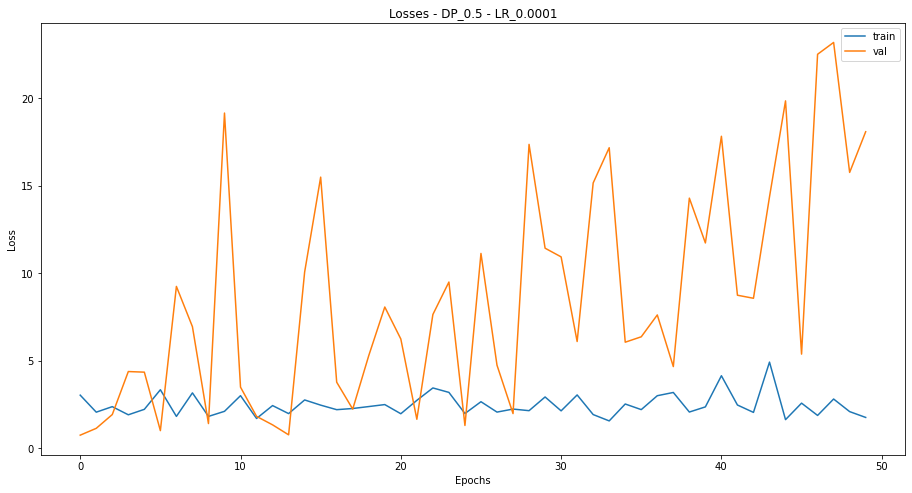

In [56]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_axes([0,0,1,1])

ax.plot(np.arange(0,50),history.history['loss'])
ax.plot(np.arange(0,50),history.history['val_loss'])
ax.set_title('Losses - DP_0.5 - LR_0.0001')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(['train', 'val'])

Text(0.5, 1.0, 'Val. Accuracy - DP_0.5 - LR_0.0001')

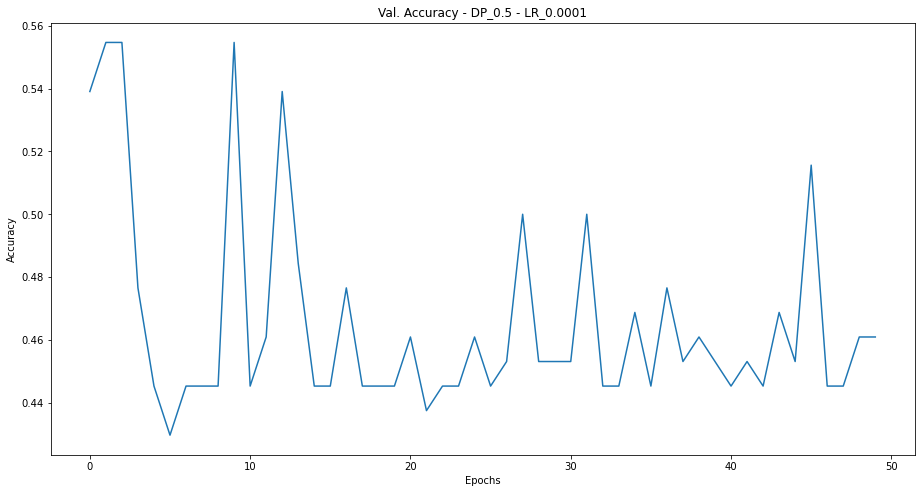

In [57]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_axes([0,0,1,1])

ax.plot(np.arange(0,50),history.history['val_accuracy'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Val. Accuracy - DP_0.5 - LR_0.0001')

Text(0.5, 1.0, 'Train Accuracy - DP_0.5 - LR_0.0001')

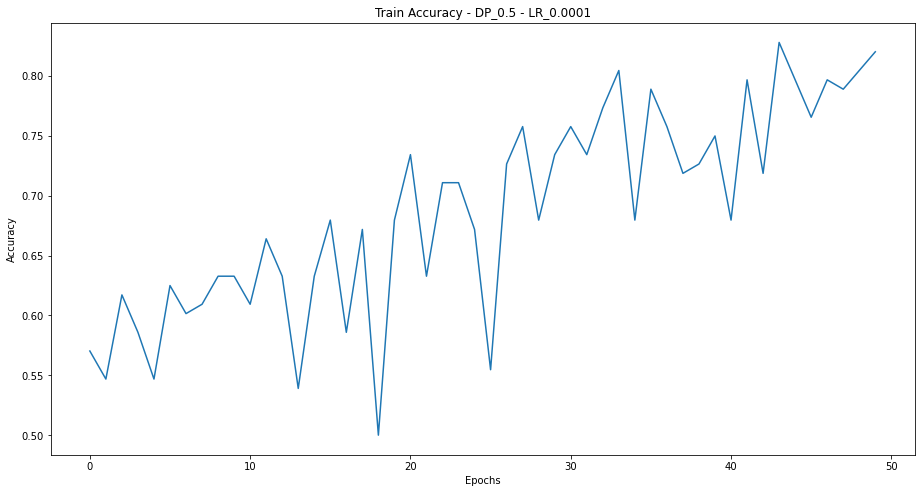

In [58]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_axes([0,0,1,1])

ax.plot(np.arange(0,50),history.history['accuracy'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Train Accuracy - DP_0.5 - LR_0.0001')

In [52]:
 # evaluate the model
acc = model_cnn.evaluate(testx, Y_test, verbose=0)